## Для данного проекта я выбрал данные из хакатона, в которым принял участие еще зимой 2023 года, когда был молод и глуп https://cs.hse.ru/sberhack/
### Постановка задачи: “Необходимо предсказать вероятность пола для каждого ID клиента - “client_id”, который присутствует в файле train.csv

### Для бизнеса важно понимать какого пола пользователь, чтобы вдальнейшем делать какие-либо персональные предложения
### За основу берется метрка ROC-AUC, так было в оригинальном хакатоне

# LIBS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as p
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import eli5
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.metrics import RocCurveDisplay

## Данные

In [2]:
def download_csv(path):
    download = path
    return "https://drive.google.com/uc?id=" + download.split("/")[-2]

trans_types = pd.read_csv(download_csv('https://drive.google.com/file/d/11Lhp8UKhd3ZsMk6VKAil9-Jh3E8Zqw5Q/view?usp=sharing'), sep=';')
# исследуемый файл очень большой ~300мб, поэтому его необходимо предварительно скачать по этой ссылке 
# https://drive.google.com/file/d/15_yTdfRpS23zQWu0HRjUmknN3Ov4Kinu/view?usp=sharing
transactions = pd.read_csv('transactions.csv')
train_part = pd.read_csv(download_csv('https://drive.google.com/file/d/1k8CEy9zyzOz7KYikwipp394_3S3r1QN6/view?usp=sharing'), sep=',')
# train_supervised_dataset = pd.read_csv(download_csv('https://drive.google.com/file/d/1o-wBTJIwMQvt5p9hYS3VzhAmGrzPG43v/view?usp=sharing'), sep=',')
# test_part = pd.read_csv(download_csv('https://drive.google.com/file/d/1bQH76ERLxZ72ee3twSN2ocEf549XA9w3/view?usp=sharing'), sep=',')
mcc_codes = pd.read_csv(download_csv('https://drive.google.com/file/d/160AeAXXnE8HwUXiBW6RqlFw_DKIQ7kaF/view?usp=sharing'), sep=';' , on_bad_lines='skip')


# Сначала посмотрим на таблицы

In [3]:
transactions

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg
...,...,...,...,...,...,...,...
3563524,e91858185ae43cf3970220748893a01b,328 13:45:38,6010,7070,227.40,888907,Penza
3563525,429b6c8255f13bdb506fdbd6e342ccb1,10 19:22:35,4814,1030,-1084.44,NaN,Khabarovsk
3563526,9443b6a0d948cf368d8d72eb295bdfdf,167 23:59:15,5411,1110,-569.20,NaN,Tver
3563527,1be75d38ad89c0f2b4d85b95f0fd8069,101 23:59:03,5814,1110,-71.43,NaN,Vladivostok


## Точная дата транзакций не определена - история транзакций каждого клиента начинается с “дня 0”

# Давайте поверхностно просмотрим на наши данные

# Train part

In [4]:
train_part = train_part.drop(columns=['Unnamed: 0'])
train_part

,client_id,gender
0,c5f18a1d1d83fda62e51e6ae1d7b8911,1
1,4b6861803556de90249e13d7cf66f0a9,0
2,7d3f908e1cd1e3624a1445df5e04c4fa,1
3,40c585a809c1bd17dc6d283d61acd2d2,0
4,5bd2ff9f6c591353577488b0dfca6dea,0
...,...,...
7555,596baadc284cb94a91c1fdd7a422a022,0
7556,9b317a4cff6bb3b630cd966f68db410b,0
7557,eb3b544e3c5293739f09dcd71a649b18,0
7558,e1c1a70bfcb000d1188745cef71b3b61,0


# trans_types 
## Здесь перечислены типы переводов

In [5]:
trans_types

,trans_type,trans_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...
...,...,...
150,2990,Списание по требованию
151,2992,Списание средств для погашения задолженности п...
152,3001,Комиссия за обслуживание ссудного счета
153,3030,Плата за обслуживание банковской карты (за пос...


# mcc_codes - Коды, которые отражают категорию услуги

In [6]:
mcc_codes

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело
...,...,...
179,9211,"Судовые выплаты, включая алименты и детскую по..."
180,9222,Штрафы
181,9311,Налоговые платежи
182,9399,"Правительственные услуги, нигде ранее не класс..."


# Разберем подробнее transactions

In [7]:
transactions

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg
...,...,...,...,...,...,...,...
3563524,e91858185ae43cf3970220748893a01b,328 13:45:38,6010,7070,227.40,888907,Penza
3563525,429b6c8255f13bdb506fdbd6e342ccb1,10 19:22:35,4814,1030,-1084.44,NaN,Khabarovsk
3563526,9443b6a0d948cf368d8d72eb295bdfdf,167 23:59:15,5411,1110,-569.20,NaN,Tver
3563527,1be75d38ad89c0f2b4d85b95f0fd8069,101 23:59:03,5814,1110,-71.43,NaN,Vladivostok


In [8]:
transactions.describe() , transactions.info(), transactions.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563529 entries, 0 to 3563528
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   client_id   object 
 1   trans_time  object 
 2   mcc_code    int64  
 3   trans_type  int64  
 4   amount      float64
 5   term_id     object 
 6   trans_city  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 190.3+ MB


(           mcc_code    trans_type        amount
 count  3.563529e+06  3.563529e+06  3.563529e+06
 mean   5.586428e+03  2.439774e+03 -6.900207e+02
 std    6.042006e+02  2.215307e+03  1.737359e+04
 min    7.420000e+02  1.000000e+03 -4.338732e+06
 25%    5.211000e+03  1.030000e+03 -7.223400e+02
 50%    5.541000e+03  1.110000e+03 -1.815200e+02
 75%    6.010000e+03  2.370000e+03 -3.706000e+01
 max    9.402000e+03  8.146000e+03  4.700293e+06,
 None,
 client_id           0
 trans_time          0
 mcc_code            0
 trans_type          0
 amount              0
 term_id       1443778
 trans_city          0
 dtype: int64)

In [9]:
transactions.client_id.value_counts()

client_id
fbf94bb37e250669ea74b20ddaa89e0e    84313
e91858185ae43cf3970220748893a01b    14404
210a288dba0bd3bf6ce90f1f1b188951    13876
7364b8067c0c257b45efd73c3d0a4028    11699
07e279042b1da23710fa2f65034d30b9    11447
                                    ...  
6c7f123d86783792cfb2a889618cfeb9        1
9ddcff2c9ed8762df62e75ab13b2838c        1
b6714c0ca16193cbd419623eb70b1488        1
ee4c5d78cbb27771979714ffa903ef5d        1
69c0bee7e4b32fec8b3038548de2581e        1
Name: count, Length: 8400, dtype: int64

In [10]:
'--------------mcc_code',  transactions.mcc_code.value_counts(),  '--------------trans_type', transactions.trans_type.value_counts()


('--------------mcc_code',
 mcc_code
 6011    772549
 4814    521102
 5411    512295
 6010    479323
 4829    314746
          ...  
 7629        30
 8244        29
 5697        23
 2741        22
 6513        14
 Name: count, Length: 184, dtype: int64,
 '--------------trans_type',
 trans_type
 1010    850980
 2010    553922
 1030    512696
 1110    490488
 7070    323669
          ...  
 4200         8
 8146         5
 4045         4
 1510         4
 4035         2
 Name: count, Length: 75, dtype: int64)

In [11]:
mcc_codes[mcc_codes['mcc_code'] == 6011]['mcc_description'], trans_types[trans_types['trans_type'] == 1010]['trans_description']

(124    Финансовые институты — снятие наличности автом...
 Name: mcc_description, dtype: object,
 98    Покупка. POS ТУ СБ РФ
 Name: trans_description, dtype: object)

In [12]:
'--------------term_id', transactions.term_id.value_counts() , '--------------trans_city', transactions.trans_city.value_counts()

('--------------term_id',
 term_id
 888991      38405
 888986      38315
 888992      38311
 888990      38292
 888993      38146
             ...  
 NXY25066        1
 50118015        1
 855657          1
 809744          1
 29214566        1
 Name: count, Length: 305010, dtype: int64,
 '--------------trans_city',
 trans_city
 Kaliningrad         429355
 Moscow              395422
 Saint Petersburg    370023
 Penza               366916
 Kazan               344660
 Vladimir            343951
 Tver                333489
 Novosibirsk         331498
 Khabarovsk          331141
 Vladivostok         317074
 Name: count, dtype: int64)

# term_id - очень много разных наименований (более 300к)

# Объединим train часть с общий датасетом по client_id, чтобы получить целную часть для обучения и выделения теста

In [13]:
train_merge = pd.merge(transactions, train_part, how="right", on=["client_id"])
train_merge

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city,gender
0,c5f18a1d1d83fda62e51e6ae1d7b8911,161 11:43:53,5411,1010,-471.74,NaN,Tver,1
1,c5f18a1d1d83fda62e51e6ae1d7b8911,175 08:32:41,5983,1110,-406.87,NaN,Tver,1
2,c5f18a1d1d83fda62e51e6ae1d7b8911,132 19:21:11,5411,1110,-587.78,NaN,Tver,1
3,c5f18a1d1d83fda62e51e6ae1d7b8911,302 19:17:03,5411,1010,-148.12,448743,Tver,1
4,c5f18a1d1d83fda62e51e6ae1d7b8911,12 11:53:29,5983,1110,-950.73,NaN,Tver,1
...,...,...,...,...,...,...,...,...
3238727,e4347a1a2a6c2bc66818209d74d415e2,168 11:52:33,6010,7070,1446.22,NaN,Novosibirsk,0
3238728,e4347a1a2a6c2bc66818209d74d415e2,320 16:04:14,6011,2010,-433.79,10087236,Novosibirsk,0
3238729,e4347a1a2a6c2bc66818209d74d415e2,435 16:06:57,4814,1030,-36.96,888930,Novosibirsk,0
3238730,e4347a1a2a6c2bc66818209d74d415e2,218 13:00:29,6011,2010,-1084.91,110200,Novosibirsk,0


In [14]:
train_merge['trans_time'].value_counts()

trans_time
294 00:00:41    21
449 00:00:27    21
291 23:59:50    21
302 00:01:00    21
455 00:00:22    21
                ..
383 14:52:57     1
390 04:33:22     1
52 02:57:19      1
202 03:04:46     1
447 16:18:44     1
Name: count, Length: 2764142, dtype: int64

# Бейзлайн
## Необходимо преобразовать данные, чтобы как-то их начать исследовать
## Пока отброшу client_id и term_id
### Преобразую колонку с днем и временем

In [15]:
# выделяю обучающие данные
baseline_df_train = train_merge[['mcc_code', 'trans_type', 'amount', 'trans_city', 'gender']]

train_df = baseline_df_train.copy()

# разделяю колонку с днем и временем и обрабатываю время в секунды
train_df['trans_time'] = train_merge['trans_time']
train_df[['day','time']] = train_merge['trans_time'].str.split(' ',expand=True)
train_df = train_df.drop('trans_time', axis=1)

def time_to_sec(t):
   h, m, s = map(int, t.split(':'))
   return h * 3600 + m * 60 + s

train_df['time'] = train_df['time'].apply(lambda x: time_to_sec(x))
train_df

# baseline_df[baseline_df['term_id'] == 'N3918096']
# .fillna(0).astype({"term_id": int})

,mcc_code,trans_type,amount,trans_city,gender,day,time
0,5411,1010,-471.74,Tver,1,161,42233
1,5983,1110,-406.87,Tver,1,175,30761
2,5411,1110,-587.78,Tver,1,132,69671
3,5411,1010,-148.12,Tver,1,302,69423
4,5983,1110,-950.73,Tver,1,12,42809
...,...,...,...,...,...,...,...
3238727,6010,7070,1446.22,Novosibirsk,0,168,42753
3238728,6011,2010,-433.79,Novosibirsk,0,320,57854
3238729,4814,1030,-36.96,Novosibirsk,0,435,58017
3238730,6011,2010,-1084.91,Novosibirsk,0,218,46829


# Посмотрим корреляцию

<Axes: >

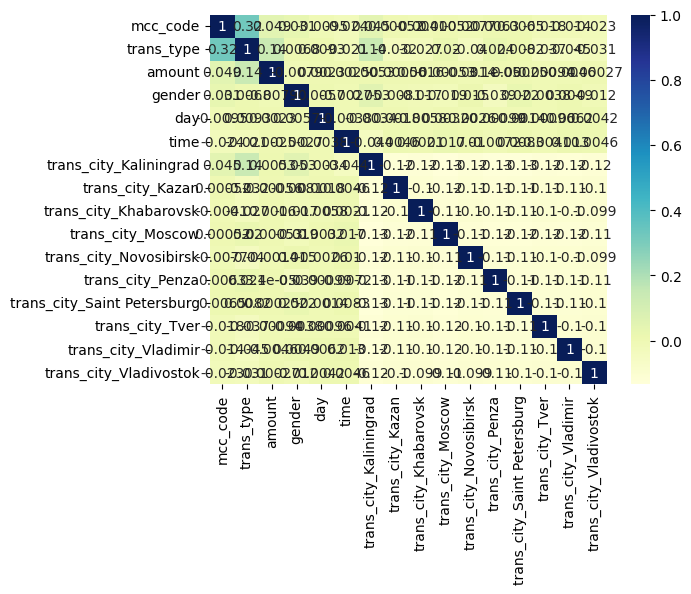

In [16]:
corr_df = pd.get_dummies(train_df, columns=['trans_city'], dtype=float).astype(float)
sb.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)

# Видно, что зависимости слабые, кроме mcc_code + trans_type

# Баланс классов обучающих данных

In [17]:
train_df['gender'].value_counts()

gender
0    1677628
1    1561104
Name: count, dtype: int64

# Обучающие данные достаточно сбалансированы

# Лог. Рег.

Линейная регрессия $\hat{y} = w_0x_0 + \ldots w_nx_n$ "умеет" предсказывать величины от $-\infty$ до $\infty$. Мы берем за основу ее, но 

Превращаем логарифм в экспоненту
$$
\exp(\overline{w}x) = \frac{p}{1-p}
$$

И выражаем вероятность успеха $p$ для конкретного объекта $x_i$:
$$
p_i = \frac{1}{1+e^{-\overline{w}x_i}}
$$

Поулчается функция сигмоиды, которая лежит в основе работы алгоритма 
$$
f(x) = \frac{1}{1+e^{-z}}
$$


Но для подбора оптимального веса уже используется метод максимального правдоподобия

$$
L(y, X, w) = - \sum_{i}^{N} y_i \log \sigma (z) + (1-y_i)\log(\sigma (-z))
$$

В результате получается функция "бинарная кросс-энтропия"

$$
\nabla L = \frac{1}{N}\left(Y - \hat{Y}\right)\cdot X
$$



In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['gender']), train_df['gender'], test_size=0.1, random_state=42)

# Сделаем OneHot кодирование отдельно для трэин и теста, чтобы избежать лика в данных

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(pd.get_dummies(X_train, columns=['trans_city'], dtype=float))
X_test = scaler.transform(pd.get_dummies(X_test, columns=['trans_city'], dtype=float))

# ROC_AUC

Простым языком метрика показывает производительность модели к корректному отличию FPR и TPR на разных отсечках

FPR = TP деленный на весь положительный класс - должна стремиться к 1
$$

FPR  = \frac{TP}{TP + FN}
$$
TPR = FP деленный на весь отрицательный класс - должна стремиться к 0
$$

TPR  = \frac{FP}{FP + TN}
$$

Таким образом, мы смотрим эти соотношения для отсечек от 0 до 1 и исследуем как хорошо модель может корректно распознавать классы на разных отсечках
Далее на графике ROC-AUC откладываются точки со значениями точек TPR и FPR. В идеале, чтобы график доходил до значения 1 по оси TPR, находясь в точке 0 по оси FPR. Далее считается площадь под этой кривой, чтобы получить эту самую метрику ROC-AUC

# Воспользуемся реализацией GridSearchCV, чтобы удобно прогнать лог рег с разными параметрами и выбрать лучшие

In [20]:
# 'solver': 'lbfgs' - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
#  Данных много, поэтому остановимся на 'saga', 'sag'

parameters = [{'solver': ['saga', 'sag']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']}]

log_reg = LogisticRegression()

grid_search = GridSearchCV(estimator = log_reg,  
                           param_grid = parameters,
                           scoring = 'roc_auc')


grid_search.fit(X_train, y_train)

c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To ke

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'solver': ['saga', 'sag']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']}],
             scoring='roc_auc')

# Best_score

In [21]:
grid_search.best_score_, grid_search.best_params_

(0.5449237150599989, {'solver': 'sag'})

# Проверим результат

In [22]:
log_reg = LogisticRegression(solver='saga', penalty=None).fit(X_train, y_train)

predicted_classes = log_reg.predict(X_test)
rocauc = roc_auc_score(y_test ,predicted_classes)
'roc_auc_score' , rocauc

('roc_auc_score', 0.530407649540799)

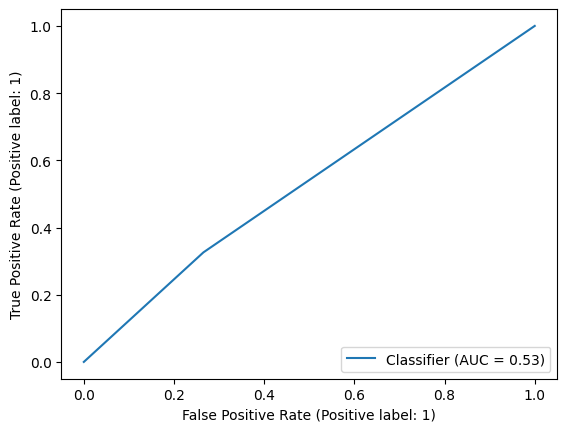

In [23]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test ,predicted_classes)

In [24]:

eli5.show_weights(log_reg, feature_names=pd.get_dummies(train_df.drop(columns=['gender']), columns=['trans_city']).columns.tolist())

Weight?,Feature
+0.094,trans_city_Kaliningrad
+0.065,mcc_code
+0.040,trans_city_Saint Petersburg
+0.026,trans_city_Novosibirsk
+0.013,day
+0.009,trans_city_Vladimir
+0.000,time
-0.007,trans_city_Tver
-0.015,trans_city_Kazan
-0.017,trans_type


# Достаточно плохой результат. Попробую более мощный алгоритм 


## Дерево решений
Само по себе дерево в каждом узле разбивает выборку на две части по какому-либо признаку. 
Как производится разбиение.
На задачу бинарной классфикации $p_0$ - вероятность принадлежности объекта к "негативному" классу и $p_1$ - вероятность принадлежности объекта к "позитивному" классу. Тогда возможных состояний всего два и формула приобретает вид

$$
H(X) = - p_0\log_2(p_0) - p_1\log_2(p_1)
$$

Простым языком дерево строится чтобы снизить неопределённость, т.е. на каждом шаге необходимо выбирать такой порог и признак, чтобы получить максимальный выигрыш информации.
Пространство как бы нарезается на сплиты, чтобы максимизировать информацию

# Ансамблевые алгоритмы Bagging (голосуем за лучший алгоритм) и Boosting (исправляем ошибку предыдущего алгоритма)

Bagging
$$
a(x) = \frac{1}{m}\sum_{i=1}^n a_i(x)
$$

Boosting
$$
F(x) = \sum_{i=1}^n y_ih_i(x) + const
$$

# В моем случае взял реализацию LGBMClassifier


In [25]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

rocauc = roc_auc_score(y_test, y_pred)
'roc_auc_score' , rocauc

[LightGBM] [Info] Number of positive: 1404695, number of negative: 1510163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 2914858, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481909 -> initscore=-0.072397
[LightGBM] [Info] Start training from score -0.072397


('roc_auc_score', 0.6108142006311134)

# roc_auc_score 0.6108142006311134

# Попробуем преобразовать данные

In [26]:
proccessing_data = train_merge[['client_id', 'mcc_code', 'trans_type', 'amount', 'trans_city', 'gender']]

train_df = proccessing_data.copy()

# разделяю колонку с днем и временем и обрабатываю время в секунды
train_df['trans_time'] = train_merge['trans_time']
train_df[['day','time']] = train_merge['trans_time'].str.split(' ',expand=True)
train_df = train_df.drop('trans_time', axis=1)

def time_to_sec(t):
   h, m, s = map(int, t.split(':'))
   return h * 3600 + m * 60 + s

train_df['time'] = train_df['time'].apply(lambda x: time_to_sec(x))
train_df

,client_id,mcc_code,trans_type,amount,trans_city,gender,day,time
0,c5f18a1d1d83fda62e51e6ae1d7b8911,5411,1010,-471.74,Tver,1,161,42233
1,c5f18a1d1d83fda62e51e6ae1d7b8911,5983,1110,-406.87,Tver,1,175,30761
2,c5f18a1d1d83fda62e51e6ae1d7b8911,5411,1110,-587.78,Tver,1,132,69671
3,c5f18a1d1d83fda62e51e6ae1d7b8911,5411,1010,-148.12,Tver,1,302,69423
4,c5f18a1d1d83fda62e51e6ae1d7b8911,5983,1110,-950.73,Tver,1,12,42809
...,...,...,...,...,...,...,...,...
3238727,e4347a1a2a6c2bc66818209d74d415e2,6010,7070,1446.22,Novosibirsk,0,168,42753
3238728,e4347a1a2a6c2bc66818209d74d415e2,6011,2010,-433.79,Novosibirsk,0,320,57854
3238729,e4347a1a2a6c2bc66818209d74d415e2,4814,1030,-36.96,Novosibirsk,0,435,58017
3238730,e4347a1a2a6c2bc66818209d74d415e2,6011,2010,-1084.91,Novosibirsk,0,218,46829


In [27]:
len(train_df['mcc_code'].unique()), len(train_df['trans_type'].unique())

(184, 75)

# mcc_code и trans_type попробуем закодировать через LabelEncoder, т.к. тоже большая разница в значениях, но по сути это категории

In [28]:
le = preprocessing.LabelEncoder()

In [29]:
train_df['mcc_code'] = le.fit_transform(train_df['mcc_code'])
train_df['trans_type'] = le.fit_transform(train_df['trans_type'])
train_df['client_id'] = le.fit_transform(train_df['client_id'])
train_df

,client_id,mcc_code,trans_type,amount,trans_city,gender,day,time
0,5898,56,1,-471.74,Tver,1,161,42233
1,5898,117,4,-406.87,Tver,1,175,30761
2,5898,56,4,-587.78,Tver,1,132,69671
3,5898,56,1,-148.12,Tver,1,302,69423
4,5898,117,4,-950.73,Tver,1,12,42809
...,...,...,...,...,...,...,...,...
3238727,6781,123,68,1446.22,Novosibirsk,0,168,42753
3238728,6781,124,10,-433.79,Novosibirsk,0,320,57854
3238729,6781,20,2,-36.96,Novosibirsk,0,435,58017
3238730,6781,124,10,-1084.91,Novosibirsk,0,218,46829


<Axes: >

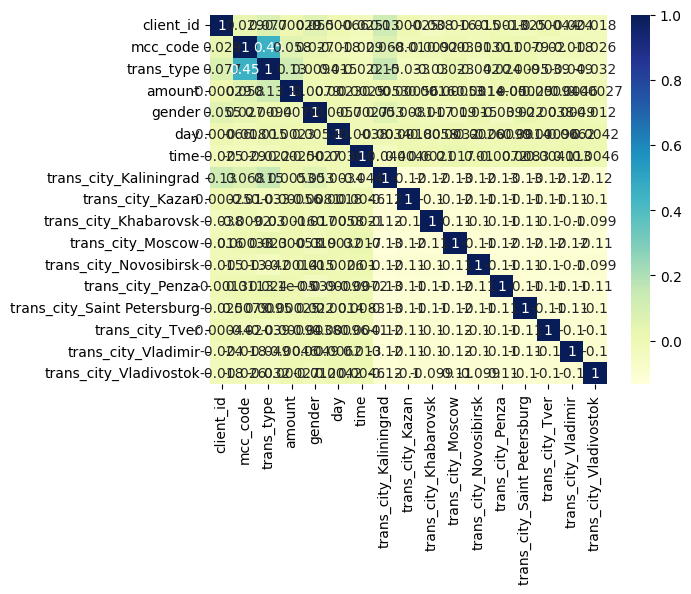

In [30]:
corr_df = pd.get_dummies(train_df, columns=['trans_city'], dtype=float).astype(float)
sb.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)

# Зависимости стали немного сильнее

# Попробуем обучить модель и поковырять гипер-параметры

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['gender']), train_df['gender'], test_size=0.1, random_state=42)

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(pd.get_dummies(X_train, columns=['trans_city'], dtype=float))
X_test = scaler.transform(pd.get_dummies(X_test, columns=['trans_city'], dtype=float))

# Далее я итеративно руками подбирал гиперпараметры

In [33]:
# Создание и обучение модели
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.3,
    'feature_fraction': 0.8, # select % of features at the beginning of constructing each tree. 
                             # This reduces the total number of splits that have to be evaluated to add each tree node.
    'max_depth': -1,
    'n_estimators': 250,
    # 'reg_alpha': 0.2,
    # 'reg_lambda': 0.5,

}

model = lgb.train(params, train_data, valid_sets=[test_data])

# Оценка модели
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC-AUC: {roc_auc:.4f}')

c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1404695, number of negative: 1510163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 2914858, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481909 -> initscore=-0.072397
[LightGBM] [Info] Start training from score -0.072397
ROC-AUC: 0.8959


# Уже отличный результат ROC-AUC: 0.8959

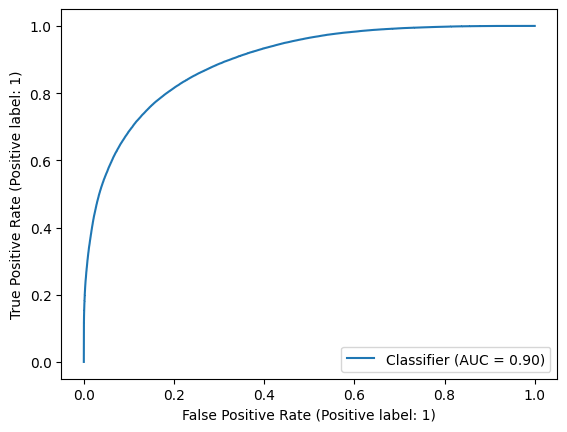

In [34]:
RocCurveDisplay.from_predictions(y_test, y_pred)

## Кажется, что время может оказывать слишком сильное влияние на результат из-за таких огромных занчений, поэтому попробуем убрать его и попробовать тоже самое

In [35]:
train_df_notime = train_df.drop(columns=['time'], axis=1)
train_df_notime

,client_id,mcc_code,trans_type,amount,trans_city,gender,day
0,5898,56,1,-471.74,Tver,1,161
1,5898,117,4,-406.87,Tver,1,175
2,5898,56,4,-587.78,Tver,1,132
3,5898,56,1,-148.12,Tver,1,302
4,5898,117,4,-950.73,Tver,1,12
...,...,...,...,...,...,...,...
3238727,6781,123,68,1446.22,Novosibirsk,0,168
3238728,6781,124,10,-433.79,Novosibirsk,0,320
3238729,6781,20,2,-36.96,Novosibirsk,0,435
3238730,6781,124,10,-1084.91,Novosibirsk,0,218


In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_df_notime.drop(columns=['gender']), train_df_notime['gender'], test_size=0.1, random_state=42)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(pd.get_dummies(X_train, columns=['trans_city'], dtype=float))
X_test = scaler.transform(pd.get_dummies(X_test, columns=['trans_city'], dtype=float))

In [42]:
# Создание и обучение модели
train_data = lgb.Dataset(X_train, label=y_train)
# valid_data

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.3,
    'feature_fraction': 0.8, # select % of features at the beginning of constructing each tree. 
                             # This reduces the total number of splits that have to be evaluated to add each tree node.
    'max_depth': -1,
    'n_estimators': 250,
    # 'reg_alpha': 0.2,
    # 'reg_lambda': 0.5,

}

model = lgb.train(params, train_data)

# Оценка модели
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC-AUC: {roc_auc:.4f}')

c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1404695, number of negative: 1510163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 2914858, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481909 -> initscore=-0.072397
[LightGBM] [Info] Start training from score -0.072397
ROC-AUC: 0.9004


# Стало еще чуть лучше ROC-AUC: 0.9004 Попробую еще поменять гипер-параметры

In [43]:
# Создание и обучение модели
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 50, # было 31
    'learning_rate': 0.3,
    'feature_fraction': 0.8, # select % of features at the beginning of constructing each tree. 
                             # This reduces the total number of splits that have to be evaluated to add each tree node.
    'max_depth': -1,
    'n_estimators': 350, # было 250
    'subsample_for_bin': 100000 # было 200000. Вообще странно, что это дало прирост в метрике, 
                                # т.к. по сути нужно для снижения потребления памяти и ускорения работы алгоритма
    # 'reg_alpha': 0.2,
    # 'reg_lambda': 0.5,

}

model = lgb.train(params, train_data)

# Оценка модели
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'ROC-AUC: {roc_auc:.4f}')

c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1404695, number of negative: 1510163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 2914858, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481909 -> initscore=-0.072397
[LightGBM] [Info] Start training from score -0.072397
ROC-AUC: 0.9260


# Изменил параметры: subsample_for_bin, n_estimators, num_leaves. Получилось добиться ROC-AUC: 0.9260

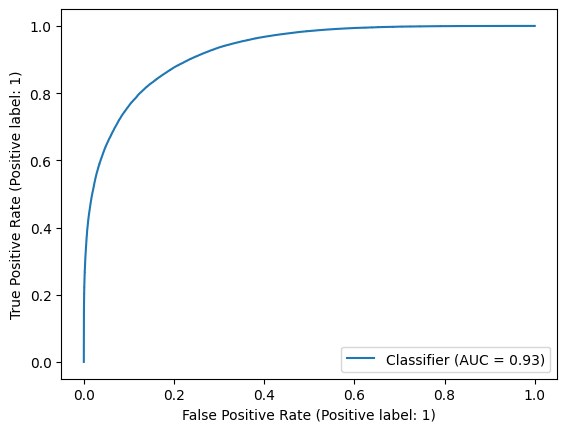

In [44]:
RocCurveDisplay.from_predictions(y_test, y_pred)

# Если бы были конкретные даты, то можно было бы исследовать дни на предмет праздников и как-то это соотнести с гендером, например